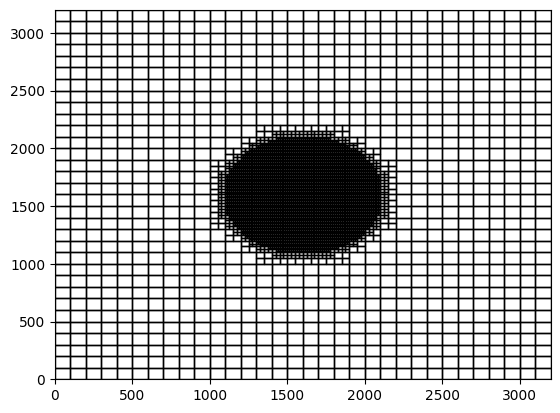

In [1]:
import flopy
import flopy.utils.gridgen as gridgen
import shapely.geometry as sg

# --- Define base structured grid parameters
Lx = Ly = 3200.0
nrow = ncol = 32
delr = delc = Lx / ncol

# --- Create a MODFLOW model (or directly a StructuredGrid)
sim = flopy.mf6.MFSimulation()
gwf = flopy.mf6.ModflowGwf(sim)
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    nlay=1,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=0,
    botm=-10,
)
modelgrid = gwf.modelgrid   # StructuredGrid object

# --- Initialize Gridgen using the StructuredGrid
g = gridgen.Gridgen(
    modelgrid,
    model_ws="gridgen_ws",       # working directory
    exe_name="gridgen",          # path to USGS gridgen executable
)

# --- Define polygon region for refinement
refine_poly = sg.Point(1600, 1600).buffer(500)  # circle of radius 500 m

# --- Add refinement levels
for level in range(3):
    g.add_refinement_features([refine_poly], 'polygon', layers=[0], level=level+1)

# --- Build the quadtree
g.build()

# --- Extract DISV2-style grid data
vertices = g.get_vertices(nodenumber=True)
ncells = g.nodes
cell2d   = g.get_verts_iverts(ncells=ncells)  # cell-to-vertex connectivity

# --- Optional: visualize
g.plot()


In [ ]:
disv = g.get_gridprops_disv()
vertices = disv['vertices']
cell2d = disv['cell2d']

print("Number of vertices:", len(vertices))
print("Number of cells:", len(cell2d))




In [2]:
flopy.__version__

'3.10.0.dev5'

In [10]:
import numpy as np
import flopy
from shapely.geometry import Point

# Assume you already have a Gridgen object g and have built it
# g.build() has already been called

# Extract cell center coordinates
cellcenters = g.get_center(nodenumber=True)  # returns (x, y) for each cell
cellcenters = np.array(cellcenters)

# Example: you want the cell containing the point (x_query, y_query)
x_query, y_query = 1200.0, 1500.0
point = Point(x_query, y_query)

# --- Find the nearest cell by checking which cell contains the point ---
# Method 1: Use distance to cell center (simple, approximate)
dist = np.linalg.norm(cellcenters - np.array([x_query, y_query]), axis=0)
cellid_nearest = np.argmin(dist)

print("Nearest cell ID:", cellid_nearest)

# Method 2: More accurate: check polygon containment
# You need the vertices of each cell
vertices = np.array(g.get_vertices(nodenumber=False))  # shape (nverts, 2)
iverts = g.get_verts_iverts(len(vertices))            # cell-to-vertex connectivity

# Build Shapely polygons for each cell
from shapely.geometry import Polygon

cell_polygons = [Polygon(vertices[iv]) for iv in iverts]

# Find which cell contains the query point
for cid, poly in enumerate(cell_polygons):
    if poly.contains(point):
        cellid_containing = cid
        break

print("Cell containing point:", cellid_containing)


Nearest cell ID: 0


IndexError: arrays used as indices must be of integer (or boolean) type

In [11]:
np.array([x_query, y_query])
np.linalg.norm(cellcenters - np.array([x_query, y_query]), axis=0)
iverts = g.get_verts_iverts(len(vertices))
iverts

(array([[   0., 3200.],
        [ 100., 3200.],
        [ 100., 3100.],
        [   0., 3100.],
        [ 200., 3200.],
        [ 200., 3100.],
        [ 300., 3200.],
        [ 300., 3100.],
        [ 400., 3200.],
        [ 400., 3100.],
        [ 500., 3200.],
        [ 500., 3100.]]),
 [[0, 1, 2, 3, 0],
  [1, 4, 5, 2, 1],
  [4, 6, 7, 5, 4],
  [6, 8, 9, 7, 6],
  [8, 10, 11, 9, 8]])